In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
import matplotlib
import pybedtools
import os
try:
    os.mkdir('tmp')
except:
    pass
pybedtools.helpers.set_tempdir('tmp')


In [2]:
DESeq2_results_path = '../all_sites/ER_diff_DEseq2_results.txt'
MBC_peak_loc_path = '../../raw_TCGA/BRCA_peak_locations.txt'
hem_peak_loc_path = '../../../hematopoietic/sites_hg38/GSE129785_scATAC-Hematopoiesis-All.peaks_hg38.bed'


In [3]:
results = pd.read_csv(DESeq2_results_path, sep='\t')

#peak locations
MBC_peak_loc = pd.read_csv(MBC_peak_loc_path, sep='\t')
print(len(MBC_peak_loc))
MBC_peak_loc = MBC_peak_loc.rename(columns = {'Chromosome':'Chrom'})
MBC_peak_loc['position'] = (MBC_peak_loc['Start']+MBC_peak_loc['End']-1)/2
MBC_peak_loc['position'] = MBC_peak_loc['position'].astype(int)

#drop any sites on the x chromosome or non-standard chromosomes
chroms = ['chr'+str(m) for m in range(1,23)]
MBC_peak_loc = MBC_peak_loc[MBC_peak_loc['Chrom'].isin(chroms)]
MBC_peak_loc = MBC_peak_loc.set_index('Peak_Name')
print(len(MBC_peak_loc))

results = results.merge(MBC_peak_loc[['Chrom','Start','End','position']], left_index=True, right_index=True)
print(len(results))

215920
211938
211938


In [4]:
results = results.reset_index()
results = results.rename(columns = {'index':'Peak_Name'})
results['neg_log2_padj'] = -np.log2(results['padj'])


In [5]:
hem_peak_loc = pd.read_csv(hem_peak_loc_path, sep='\t', header=None)

#drop any sites on the x chromosome or non-standard chromosomes
hem_peak_loc = hem_peak_loc[hem_peak_loc[0].isin(chroms)]

#discard 1272 peaks that change size during liftover
hem_peak_loc['width'] = hem_peak_loc[2]-hem_peak_loc[1]
print('discarding wrong length:',len(hem_peak_loc) - len(hem_peak_loc[hem_peak_loc['width']==500]))
hem_peak_loc = hem_peak_loc[hem_peak_loc['width']==500]

heme_peak_bed = pybedtools.BedTool.from_dataframe(hem_peak_loc[[0,1,2]])
heme_peak_bed.sort()
print(len(hem_peak_loc))
hem_peak_loc.head()


discarding wrong length: 1140
555525


,0,1,2,width
0,chr1,10238,10738,500
1,chr1,115476,115976,500
2,chr1,267105,267605,500
3,chr1,267760,268260,500
4,chr1,271050,271550,500


In [6]:
#covert to a bed for overlapping
MBC_peak_bed = pybedtools.BedTool.from_dataframe(results[['Chrom','Start','End']])

In [7]:
#split MBC peaks by whether they overlap heme
mbc_specific = MBC_peak_bed.subtract(heme_peak_bed, A=True)
mbc_overlaps = MBC_peak_bed.intersect(heme_peak_bed, u=True)

print('specific', len(mbc_specific))
print('overlaps', len(mbc_overlaps))

print('total', len(mbc_specific)+len(mbc_overlaps))

specific 94719
overlaps 117219
total 211938


In [8]:
#convert to data frame
#get the peak data
mbc_specific_df = mbc_specific.to_dataframe().rename(columns = {'chrom':'Chrom','start':'Start','end':'End'})
mbc_specific_df = mbc_specific_df.merge(results, on = ['Chrom','Start','End'])
print('specific',len(mbc_specific_df))


#get the peak data
mbc_overlaps_df = mbc_overlaps.to_dataframe().rename(columns = {'chrom':'Chrom','start':'Start','end':'End'})
mbc_overlaps_df = mbc_overlaps_df.merge(results, on = ['Chrom','Start','End'])
print('overlaps',len(mbc_overlaps_df))

specific 94719
overlaps 117219


In [9]:
random_sample = results.sample(frac = 0.05, random_state = 2)['Peak_Name']
random_sample

52822     BRCA_147540
45525     BRCA_140973
91661     BRCA_182497
13281     BRCA_111951
20355     BRCA_118318
             ...     
34086     BRCA_130678
51469     BRCA_146322
60414     BRCA_154373
69242     BRCA_162318
150517     BRCA_44714
Name: Peak_Name, Length: 10597, dtype: object

In [10]:
qval = 0.05
fold_changes = [0.0, 0.5, 1, 2]

FC_list_lengths_df = pd.DataFrame()
FC_list_lengths_df.index.name = 'log2FC'


#make a figure of the different log fold changes
fig,ax= plt.subplots(figsize = (3,3))

sample_set = results[results['Peak_Name'].isin(random_sample)]
sample_set = sample_set[(np.abs(sample_set['log2FoldChange'])<=min(fold_changes)) | (np.abs(sample_set['padj'])>qval)]
sample_set.plot.scatter(x = 'neg_log2_padj',y='log2FoldChange', alpha = 0.2, ax=ax, color='tab:grey', s = 10)
blue = np.array(matplotlib.colors.to_rgb('tab:blue'))
orange = np.array(matplotlib.colors.to_rgb('tab:orange'))


for i in range(len(fold_changes)):
    lfc = fold_changes[i]
    if i+1<len(fold_changes):
        next_lfc = fold_changes[i+1]
    else:
        next_lfc = np.inf
    
    FC_string = '_'.join(str(lfc).split('.'))

    positive_specific = mbc_specific_df[(mbc_specific_df['padj']<qval) & (mbc_specific_df['log2FoldChange']>lfc)]
    negative_specific = mbc_specific_df[(mbc_specific_df['padj']<qval) & (mbc_specific_df['log2FoldChange']<-lfc)]

    positive_overlaps = mbc_overlaps_df[(mbc_overlaps_df['padj']<qval) & (mbc_overlaps_df['log2FoldChange']>lfc)]
    negative_overlaps = mbc_overlaps_df[(mbc_overlaps_df['padj']<qval) & (mbc_overlaps_df['log2FoldChange']<-lfc)]

    list_lengths_dict = {'ER_positive_specific':len(positive_specific),
           'ER_negative_specific':len(negative_specific),
           'ER_positive_overlaps':len(positive_overlaps),
           'ER_negative_overlaps':len(negative_overlaps)}
        
    FC_list_lengths_df = FC_list_lengths_df.append(pd.Series(list_lengths_dict, name = lfc))
        
    #export
    positive_specific.to_csv('../sites_by_log2FC/ER_pos_specific.'+FC_string+'_FC.DESeq2.txt', sep='\t',index=False)
    negative_specific.to_csv('../sites_by_log2FC/ER_neg_specific.'+FC_string+'_FC.DESeq2.txt', sep='\t',index=False)

    positive_overlaps.to_csv('../sites_by_log2FC/ER_pos_heme.'+FC_string+'_FC.DESeq2.txt', sep='\t',index=False)
    negative_overlaps.to_csv('../sites_by_log2FC/ER_neg_heme.'+FC_string+'_FC.DESeq2.txt', sep='\t',index=False)

    #plot the data
    pos_color = tuple(1-(1-i/4)*(1-blue))
    neg_color = tuple(1-(1-i/4)*(1-orange))
    
    positive_specific[(positive_specific['log2FoldChange']<=next_lfc) & (positive_specific['Peak_Name'].isin(random_sample))].plot.scatter(x = 'neg_log2_padj',y='log2FoldChange', alpha = 0.2, ax=ax, color=pos_color, s = 10)
    negative_specific[(negative_specific['log2FoldChange']>=-next_lfc) & (negative_specific['Peak_Name'].isin(random_sample))].plot.scatter(x = 'neg_log2_padj',y='log2FoldChange', alpha = 0.2, ax=ax, color=neg_color, s = 10)
    
    positive_overlaps[(positive_overlaps['log2FoldChange']<=next_lfc) & (positive_overlaps['Peak_Name'].isin(random_sample))].plot.scatter(x = 'neg_log2_padj',y='log2FoldChange', alpha = 0.2, ax=ax, color=pos_color, s = 10)
    negative_overlaps[(negative_overlaps['log2FoldChange']>=-next_lfc) & (negative_overlaps['Peak_Name'].isin(random_sample))].plot.scatter(x = 'neg_log2_padj',y='log2FoldChange', alpha = 0.2, ax=ax, color=neg_color, s = 10)
    
    ax.axhline(y=-lfc, color='lightgrey',dashes=(2,2))
    ax.axhline(y=lfc, color='lightgrey',dashes=(2,2))
    
    
ax.set_title('BRCA ATAC sites by log2FC')
fig.tight_layout()
ax.axvline(x=-np.log2(qval), color='lightgrey',dashes=(2,2))    
fig.savefig('../plots/log2FC_butterfly_plot.pdf')
plt.close()

FC_list_lengths_df['qval']=qval
del(qval,lfc,next_lfc,fold_changes,FC_string)




In [11]:
FC_list_lengths_df

,ER_positive_specific,ER_negative_specific,ER_positive_overlaps,ER_negative_overlaps,qval
log2FC,,,,,
0.0,29540.0,29664.0,20007.0,41349.0,0.05
0.5,28782.0,28062.0,18953.0,37575.0,0.05
1.0,21209.0,20472.0,10038.0,18629.0,0.05
2.0,6227.0,6963.0,1731.0,3571.0,0.05


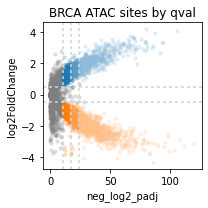

In [12]:
qval_factors = [-4,-6,-8]
max_qval = 5*10**max(qval_factors)
lfc = 0.5

#test lower p value, test out some different qvalues
qval_list_lengths_df = pd.DataFrame()
qval_list_lengths_df.index.name = 'qval'


#make a figure of the different log fold changes
fig,ax= plt.subplots(figsize = (3,3))

sample_set = results[results['Peak_Name'].isin(random_sample)]
sample_set = sample_set[(np.abs(sample_set['log2FoldChange'])<=lfc) | (np.abs(sample_set['padj'])>max_qval)]
sample_set.plot.scatter(x = 'neg_log2_padj',y='log2FoldChange', alpha = 0.2, ax=ax, color='tab:grey', s = 10)
blue = np.array(matplotlib.colors.to_rgb('tab:blue'))
orange = np.array(matplotlib.colors.to_rgb('tab:orange'))



for i in range(len(qval_factors)):
    factor = qval_factors[i]
    qval = 5*10**factor
    qval_string = '5e'+str(factor)

    if i+1<len(qval_factors):
        next_qval = 5*10**qval_factors[i+1]
    else:
        next_qval = 0
    
    positive_specific = mbc_specific_df[(mbc_specific_df['padj']<qval) & (mbc_specific_df['log2FoldChange']>lfc)]
    negative_specific = mbc_specific_df[(mbc_specific_df['padj']<qval) & (mbc_specific_df['log2FoldChange']<-lfc)]

    positive_overlaps = mbc_overlaps_df[(mbc_overlaps_df['padj']<qval) & (mbc_overlaps_df['log2FoldChange']>lfc)]
    negative_overlaps = mbc_overlaps_df[(mbc_overlaps_df['padj']<qval) & (mbc_overlaps_df['log2FoldChange']<-lfc)]

    list_lengths_dict = {'ER_positive_specific':len(positive_specific),
           'ER_negative_specific':len(negative_specific),
           'ER_positive_overlaps':len(positive_overlaps),
           'ER_negative_overlaps':len(negative_overlaps)}
    
    qval_list_lengths_df = qval_list_lengths_df.append(pd.Series(list_lengths_dict, name = qval))
      
    #export
    positive_specific.to_csv('../sites_by_qval/ER_pos_specific.'+qval_string+'_qval.DESeq2.txt', sep='\t',index=False)
    negative_specific.to_csv('../sites_by_qval/ER_neg_specific.'+qval_string+'_qval.DESeq2.txt', sep='\t',index=False)

    positive_overlaps.to_csv('../sites_by_qval/ER_pos_heme.'+qval_string+'_qval.DESeq2.txt', sep='\t',index=False)
    negative_overlaps.to_csv('../sites_by_qval/ER_neg_heme.'+qval_string+'_qval.DESeq2.txt', sep='\t',index=False)

    #plot the data
    pos_color = tuple(1-(1-i/4)*(1-blue))
    neg_color = tuple(1-(1-i/4)*(1-orange))
    
    positive_specific[(positive_specific['padj']>=next_qval) & (positive_specific['Peak_Name'].isin(random_sample))].plot.scatter(x = 'neg_log2_padj',y='log2FoldChange', alpha = 0.2, ax=ax, color=pos_color, s = 10)
    negative_specific[(negative_specific['padj']>=next_qval) & (negative_specific['Peak_Name'].isin(random_sample))].plot.scatter(x = 'neg_log2_padj',y='log2FoldChange', alpha = 0.2, ax=ax, color=neg_color, s = 10)
    
    positive_overlaps[(positive_overlaps['padj']>=next_qval) & (positive_overlaps['Peak_Name'].isin(random_sample))].plot.scatter(x = 'neg_log2_padj',y='log2FoldChange', alpha = 0.2, ax=ax, color=pos_color, s = 10)
    negative_overlaps[(negative_overlaps['padj']>=next_qval) & (negative_overlaps['Peak_Name'].isin(random_sample))].plot.scatter(x = 'neg_log2_padj',y='log2FoldChange', alpha = 0.2, ax=ax, color=neg_color, s = 10)
    
    ax.axvline(x=-np.log2(qval), color='lightgrey',dashes=(2,2))
    
    
ax.set_title('BRCA ATAC sites by qval')
fig.tight_layout()
ax.axhline(y=lfc, color='lightgrey',dashes=(2,2))    
ax.axhline(y=-lfc, color='lightgrey',dashes=(2,2))    
fig.savefig('../plots/qval_butterfly_plot.png')


qval_list_lengths_df['log2FC']=lfc
del(factor,qval_factors,qval,qval_string,next_qval,lfc)



In [13]:
qval_list_lengths_df

,ER_positive_specific,ER_negative_specific,ER_positive_overlaps,ER_negative_overlaps,log2FC
qval,,,,,
5.000000e-04,18240.0,19347.0,9930.0,22365.0,0.5
5.000000e-06,11820.0,13260.0,5600.0,13136.0,0.5
5.000000e-08,7810.0,9098.0,3303.0,7942.0,0.5


In [14]:
pybedtools.cleanup('all')

removing /fh/fast/ha_g/user/adoebley/projects/griffin_revisions_1/sites/TCGA_ATAC/ER_differential/scripts/tmp/pybedtools.2lgwi5ss.tmp
removing /fh/fast/ha_g/user/adoebley/projects/griffin_revisions_1/sites/TCGA_ATAC/ER_differential/scripts/tmp/pybedtools.yojb5f_j.tmp
removing /fh/fast/ha_g/user/adoebley/projects/griffin_revisions_1/sites/TCGA_ATAC/ER_differential/scripts/tmp/pybedtools.9rr49xib.tmp
removing /fh/fast/ha_g/user/adoebley/projects/griffin_revisions_1/sites/TCGA_ATAC/ER_differential/scripts/tmp/pybedtools.e5dhewdt.tmp
removing /fh/fast/ha_g/user/adoebley/projects/griffin_revisions_1/sites/TCGA_ATAC/ER_differential/scripts/tmp/pybedtools.ltftnemo.tmp


In [15]:
os.removedirs('tmp')

In [16]:
qval_list_lengths_df.reset_index()

,qval,ER_positive_specific,ER_negative_specific,ER_positive_overlaps,ER_negative_overlaps,log2FC
0,5.000000e-04,18240.0,19347.0,9930.0,22365.0,0.5
1,5.000000e-06,11820.0,13260.0,5600.0,13136.0,0.5
2,5.000000e-08,7810.0,9098.0,3303.0,7942.0,0.5


In [17]:
FC_list_lengths_df.reset_index()

,log2FC,ER_positive_specific,ER_negative_specific,ER_positive_overlaps,ER_negative_overlaps,qval
0,0.0,29540.0,29664.0,20007.0,41349.0,0.05
1,0.5,28782.0,28062.0,18953.0,37575.0,0.05
2,1.0,21209.0,20472.0,10038.0,18629.0,0.05
3,2.0,6227.0,6963.0,1731.0,3571.0,0.05


In [18]:
number_of_sites = FC_list_lengths_df.reset_index().append(qval_list_lengths_df.reset_index())
number_of_sites['total_sites'] = number_of_sites[['ER_positive_specific','ER_negative_specific','ER_positive_overlaps','ER_negative_overlaps']].sum(axis=1)
number_of_sites = number_of_sites[['qval','log2FC','ER_positive_specific','ER_negative_specific','ER_positive_overlaps','ER_negative_overlaps','total_sites']]
number_of_sites[['ER_positive_specific','ER_negative_specific','ER_positive_overlaps','ER_negative_overlaps','total_sites']] = number_of_sites[['ER_positive_specific','ER_negative_specific','ER_positive_overlaps','ER_negative_overlaps','total_sites']].astype(int)


In [19]:
number_of_sites.to_csv('ER_differential_sites_by_threshold.txt',sep='\t',index=False)